In [1]:
cd "../../../Downloads/NewbornEEGData-20220203T094950Z-001/NewbornEEGData/"

C:\Users\Benedetta\Downloads\NewbornEEGData-20220203T094950Z-001\NewbornEEGData


In [2]:
## provare con filtro di Jesus

In [3]:
def plot_surr(ss,dd,surrs,surrd):
    plt.rcParams['font.size'] = 19
    f = plt.figure(figsize=(10,5))
    ax = f.add_subplot(1,2,1)

    f.suptitle("Threshold: {} standard deviation".format(thre))
    pool =[]
    pool_surr =[]
    import powerlaw as pwl
    for g in range(len(surrs)):
        if g ==0:
            try:
                pwl.plot_pdf(surrs[g], color ='red', alpha =.3, lw = 1, ax = ax)
                pwl.plot_pdf(ss[g], color ='blue', alpha = .3,lw = 1, ax =ax)
            except:
                continue
        else:
            try:
                pwl.plot_pdf(surrs[g], color ='red',alpha =.3,lw = 1, ax = ax)
                pwl.plot_pdf(ss[g], color ='blue', alpha =.3,lw = 1, ax =ax)
            except:
                continue

        pool += ss[g]
        pool_surr += surrs[g]


    pwl.plot_pdf(pool, color ='blue', alpha =.9, lw = 3, ax = ax)    
    pwl.plot_pdf(pool_surr, color ='red', alpha =.9, label ='surrogate sizes', lw =3, ax = ax)  
    ax.set_xlabel(r'Avalanches sizes [$\mu V$]')
    ax.set_ylabel('pdf')
    plt.legend();

    #thre = 2
    #plt.figure()
    ax = f.add_subplot(1,2,2)

    #plt.figure(figsize=(5,5))
    pool =[]
    pool_surr =[]
    import powerlaw as pwl
    for g in range(len(surrd)):
        if g ==0:
            try:
                pwl.plot_pdf(surrd[g], color ='red', alpha =.3, lw = 1, ax = ax)
                pwl.plot_pdf(dd[g], color ='blue', alpha = .3,lw = 1, ax = ax)
            except:
                continue
        else:
            try:
                pwl.plot_pdf(surrd[g], color ='red',alpha =.3,lw = 1, ax = ax)
                pwl.plot_pdf(dd[g], color ='blue', alpha =.3,lw = 1, ax = ax)
            except:
                continue

        pool += dd[g]
        pool_surr += surrd[g]


    pwl.plot_pdf(pool, color ='blue', alpha =.9, lw = 3, ax = ax)    
    pwl.plot_pdf(pool_surr, color ='red', alpha =.9, label ='surrogate durations', lw =3, ax = ax)  
    ax.set_xlabel('Avalanches lifetimes [s]')
    ax.set_ylabel('pdf')
    plt.legend();
    plt.tight_layout();


In [4]:
def AAFT_surrogates( original_data):
        """
        Return surrogates using the amplitude adjusted Fourier transform
        method.

        Reference: [Schreiber2000]_

        :type original_data: 2D array [index, time]
        :arg original_data: The original time series.
        :rtype: 2D array [index, time]
        :return: The surrogate time series.
        """
        #  Create sorted Gaussian reference series
        gaussian = random.randn(original_data.shape[0], original_data.shape[1])
        gaussian.sort(axis=1)

        #  Rescale data to Gaussian distribution
        ranks = original_data.argsort(axis=1).argsort(axis=1)
        rescaled_data = np.zeros(original_data.shape)

        for i in range(original_data.shape[0]):
            rescaled_data[i, :] = gaussian[i, ranks[i, :]]

        #  Phase randomize rescaled data
        phase_randomized_data = \
            correlated_noise_surrogates(rescaled_data)

        #  Rescale back to amplitude distribution of original data
        sorted_original = original_data.copy()
        sorted_original.sort(axis=1)
        #print(phase_randomized_data.shape)
        ranks = phase_randomized_data.argsort(axis=1).argsort(axis=1)

        for i in range(original_data.shape[0]):
            rescaled_data[i, :] = sorted_original[i, ranks[i, :]]

        return rescaled_data



In [5]:
def correlated_noise_surrogates( original_data):

    surrogates = np.fft.rfft(original_data, axis=1)
    original_data_fft = surrogates


    #  Get shapes
    (N, n_time) = original_data.shape
    len_phase = surrogates.shape[1]

    #  Generate random phases uniformly distributed in the
    #  interval [0, 2*Pi]
    phases = random.uniform(low=0, high=2 * np.pi, size=(N, len_phase))

    #  Add random phases uniformly distributed in the interval [0, 2*Pi]
    surrogates *= np.exp(1j * phases)

    #  Calculate IFFT and take the real part, the remaining imaginary part
    #  is due to numerical errors.
    return np.ascontiguousarray(np.real(np.fft.irfft(surrogates, n=n_time,
                                                 axis=1)))

In [6]:
from ava_functions import *

In [7]:
## rigettando anche sulla base del ppp

In [8]:
def complete_surrogate(eeg_data):
    eeg_data_surr =[]
    for g in range(eeg_data.shape[0]):
        idx = np.arange(0,len(eeg_data[g]),1)
        
        np.random.shuffle(idx)

        xsurr = eeg_data[g][idx]
        eeg_data_surr.append(xsurr)
    #print(np.asarray(eeg_data_surr).shape)
    return np.asarray(eeg_data_surr)

In [9]:
np.random.permutation(np.array([1,3,4,5,5,6,7,7,8]))

array([4, 7, 1, 8, 5, 7, 3, 5, 6])

In [10]:
np.random.shuffle(np.array([2,3,4,4]))

In [11]:
def surrogate(eeg_data):
    eeg_data_surr =[]
    for g in range(eeg_data.shape[0]):
        f = np.fft.fft(eeg_data[g])
        ab = np.abs(f)
        ph = np.angle(f)
        np.random.shuffle(ph)
        
        #ph = np.array([np.random.uniform(0,1)*2*np.pi for i in range(len(ph))])
        Xsurr = ab*(np.exp(1j*ph))
        #print(Xsurr.shape)
        xsurr = np.imag(np.fft.ifft(Xsurr,))
        eeg_data_surr.append(xsurr)
    #print(np.asarray(eeg_data_surr).shape)
    return np.asarray(eeg_data_surr)


def surrogate_shift(eeg_data):
    eeg_data_surr =[]
    for g in range(eeg_data.shape[0]):
        ii =np.random.randint(int(len(eeg_data[0])/10),int(len(eeg_data[0])*0.75))
        xsurr = np.asarray(eeg_data[g,ii:].tolist() + eeg_data[g,:ii].tolist())
        #print(xsurr.shape)
        eeg_data_surr.append(xsurr)
     #print(np.asarray(eeg_data_surr).shape)
    eeg_data_surr = np.asarray(eeg_data_surr)
    #print(np.corrcoef(eeg_data_surr[1],eeg_data_surr[2])[0,1])
    #print(np.corrcoef(eeg_data[1],eeg_data[2])[0,1])
    return np.asarray(eeg_data_surr)


In [12]:
from numpy import *

surrogate(data2)
print(data2.shape)


f = np.fft.fft(data2, axis = 1)
print(f.shape)
ab = np.abs(f)
ph = np.angle(f).T
old_ph = ph[:].T


np.random.shuffle(ph)
new_ph = ph.T
Xsurr = ab*(np.exp(1j*new_ph))
xsurr2 = np.real(np.fft.ifft(Xsurr,axis = 1))

        




plt.plot(new_ph[0], lw = 4) 
plt.plot(old_ph[0],) 

plt.xlim(0,30)

In [13]:
#os.mkdir("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data")

In [14]:
### COMPARISON BETWEEN SILENCE1 AND SILENCE2

import os
import numpy as np
import scipy.signal as ss
import scipy.io
#from dfa_functions import *

subjs  = [5,6,9,11,12,13,16,17,18,19,21,23,24,25,30,33,34,35,37,39,40,45,47,49,52,53,56,57,58,60,62,63,65,66,67,68,69,71,14,20,22,27,28,29,31,41,46,64,70]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
from scipy.signal import welch
import pandas as pd
import mne

ch_names = ['F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8']
ss = []
dd = []
ss2 = []
dd2 = []

surrs =[]
surrd =[]
surrs2 =[]
surrd2 =[]

#surr2s =[]
#surr2d =[]

#surr2s2 =[]
#surr2d2 =[]



thre = 2
ch_names = np.array(ch_names)
sfreq = 500
info = mne.create_info(ch_names = list(ch_names),
                       ch_types = 'eeg',
                       sfreq = sfreq)
def find_bad_channels(data, MAX_PEAK=200, MAX_PEAK_SIGMA=15, MAX_DIST_PS=4.5e-3, OFFSET=30, fmin=1, fmax=100, 
                      verbose = False):
    idx_down, idx_up = 0, data.shape[1]
    ss = np.std(data)
    
    psds, freqs = mne.time_frequency.psd_welch(mne.io.RawArray(data/1e6, info, verbose=False), fmin=fmin, fmax=fmax, n_fft=2048, n_overlap=1024/2, verbose=False)
    psds = np.log10(psds)
    
    dist = [((tmp-psds.mean(axis=0))**2).sum() for tmp in psds]
    dist = np.array(dist) / (psds**2).sum() * 1e2
    
    rej = []
    for i, ch in enumerate(ch_names):
        delta = np.abs(data[i]).max()
    
        str_rej = str()

        if delta>MAX_PEAK or dist[i]>MAX_DIST_PS:
            rej.append(ch)
            str_rej = '-> rejected'
            str_rej += ' ('
            if delta>MAX_PEAK:
                str_rej += ' peak'
                idx = np.where(np.abs(data[i])>MAX_PEAK)[0]
            
            if dist[i]>MAX_DIST_PS:
                str_rej += ' ps'
            str_rej += ')'
            
        if verbose: print(f'* {ch}: max peak = {np.round(delta, 2)} mV ({np.round(delta/ss, 2)} std); dist ps = {np.round(dist[i],3)} '+str_rej)
        
        if delta>MAX_PEAK:
            if np.max(idx)/sfreq<OFFSET:
                idx_down = np.max([np.max(idx),idx_down])
                if verbose: print(f'[*] WARNING: Peak only in the initial part - time: {np.max(idx)/sfreq} s')
            if np.min(idx)/sfreq>180-OFFSET:
                idx_up = np.min([np.min(idx),idx_up])
                if verbose: print(f'[*] WARNING: Peak only in the last part - time: {np.min(idx)/sfreq} s')
    if verbose: print('\nBad channels:', rej, '\n')
    return rej, idx_down, idx_up


filterr =True
from scipy import signal
o = 0
for i, subj in enumerate(subjs):
    #print(f'\n\n########## SUBJ {subj} ({i+1}/{len(subjs)})##########')
    s1 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence1 (continuous).mat')
    s2 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence2 (continuous).mat')
    data = s1['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    if idx_down > 0 or idx_up < data.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data.shape[1]:
            idx_up -= 1
        data = data[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data = data[list(idx_accepted), idx_down:idx_up]
    nchan = data.shape[0]
    
    data2 = s2['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    if idx_down > 0 or idx_up < data2.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data2.shape[1]:
            idx_up -= 1
        data2 = data2[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data2 = data2[list(idx_accepted), idx_down:idx_up]
    nchan2 = data2.shape[0]
    #print(nchan, nchan2)
    
    
    if nchan >= 5 and nchan2 >=5 and subj != 53:
        
    
        b,a = signal.butter(2, 50, btype = 'lowpass',fs = 500)

        if filterr:
            dataa = signal.filtfilt(b,a, data, axis = -1)
            dataa2 = signal.filtfilt(b,a, data2, axis = -1)
        else:
            dataa = data
            dataa2 = data2
        
        
        

        xsurr =  AAFT_surrogates(dataa)
        xsurr2 =  AAFT_surrogates(dataa2)
        
     
        #print('doing')
        s,d = compute_avalanches(dataa.T,theta = thre, fs = 500, discretized=False,)
        s2,d2 = compute_avalanches(dataa2.T,theta =thre, fs = 500, discretized=False, )
        ss.append(s.tolist())
        dd.append((d*2).tolist())
        ss2.append(s2.tolist())
        dd2.append((d2*2).tolist())
        
        #print(type(d))
        
        s,d = compute_avalanches(xsurr.T,theta = thre, fs = 500, discretized=False, )
        s2,d2 = compute_avalanches(xsurr2.T,theta =thre, fs = 500, discretized=False)
        surrs.append(s.tolist())
        surrd.append((d*2).tolist())
        surrs2.append(s2.tolist())
        surrd2.append((d2*2).tolist())
     
        
        #np.save("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data/sur_sizes_silence1_subject{}.npy".format(subj), s)
        #np.save("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data/sur_sizes_silence2_subject{}.npy".format(subj), s2)  
        #np.save("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data/sur_durations_silence1_subject{}.npy".format(subj), d)  
        #np.save("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data/sur_durations_silence2_subject{}.npy".format(subj), d2)
        
        o += 1
        

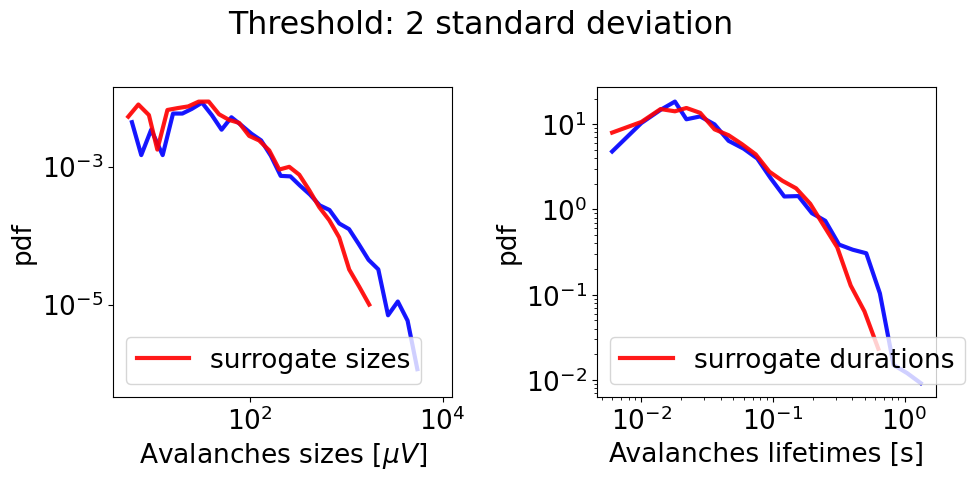

In [15]:
idx = 29

plot_surr(ss[idx:idx + 1],dd[idx:idx + 1],surrs[idx:idx +1], surrd[idx:idx+1])
#plt.xscale('linear')

In [18]:

for i, subj in enumerate(subjs):
    #print(f'\n\n########## SUBJ {subj} ({i+1}/{len(subjs)})##########')
    s1 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence1 (continuous).mat')
    s2 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence2 (continuous).mat')
    data = s1['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    if idx_down > 0 or idx_up < data.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data.shape[1]:
            idx_up -= 1
        data = data[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data = data[list(idx_accepted), idx_down:idx_up]
    nchan = data.shape[0]
    
    data2 = s2['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    if idx_down > 0 or idx_up < data2.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data2.shape[1]:
            idx_up -= 1
        data2 = data2[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data2 = data2[list(idx_accepted), idx_down:idx_up]
    nchan2 = data2.shape[0]
    #print(nchan, nchan2)
    
    
    if nchan >= 5 and nchan2 >=5 and subj != 53:
        
        

        xsurr = AAFT_surrogates(data)
        xsurr2 = AAFT_surrogates(data2)
        
        
    
        break

(0.1, 40.0)

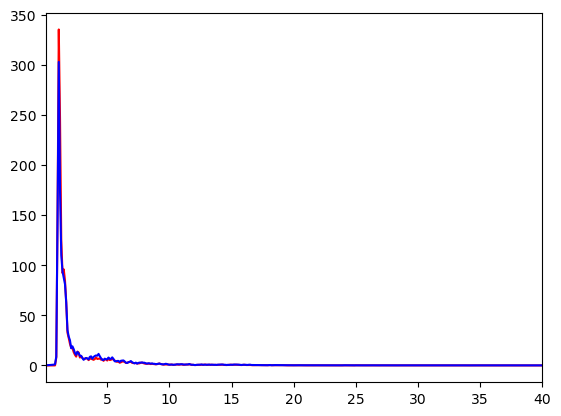

In [19]:
from scipy import signal
x,p = signal.welch(data2[2], fs = 500,nperseg = 500*10)
xsurr2 =  AAFT_surrogates(data2)

plt.plot(x,p, color = 'red')
x,p = signal.welch(xsurr2[2], fs = 500,nperseg = 500*10)
plt.plot(x,p, color = 'blue')
plt.xlim(0.1,40)
#plt.ylim(10**-6.,10**3)
#plt.xscale('log')
#plt.yscale('log')

In [36]:
avalanche(data[0][np.newaxis,:].T,0)[0]

array([65103.58807235])

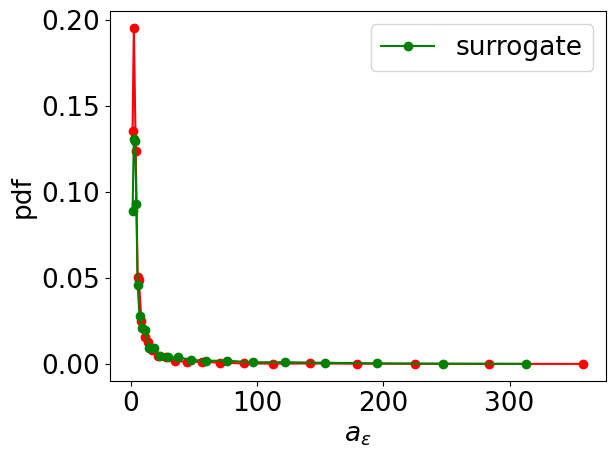

In [32]:
pwl.plot_pdf(avalanche(data2[0][np.newaxis,:].T,1)[0], color ='red',marker ='o',linear_bins=False)

pwl.plot_pdf(avalanche(xsurr[0][np.newaxis,:].T,1)[0], color ='green',marker ='o',linear_bins=False, label ='surrogate');
plt.xscale('linear')
plt.yscale('linear')
plt.legend()
plt.xlabel('$a_\epsilon$')
plt.ylabel('pdf');


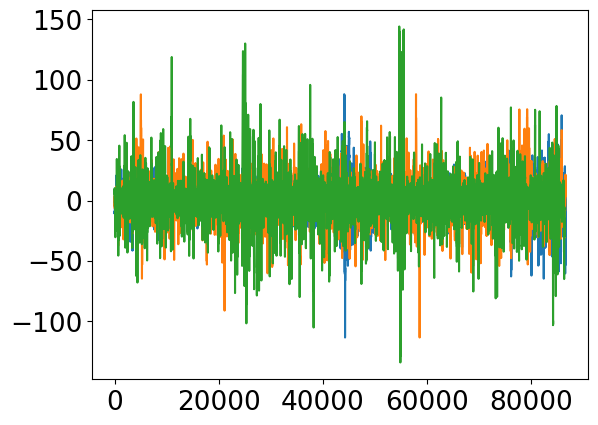

In [81]:
plt.plot(data2[0])
plt.plot(xsurr2[0])
plt.plot(xsurr2[5,100:-100])
#plt.xlim(0,100)

#plt.ylim(-40,40)

In [27]:
xsurr2.shape, data32

(10, 90967)

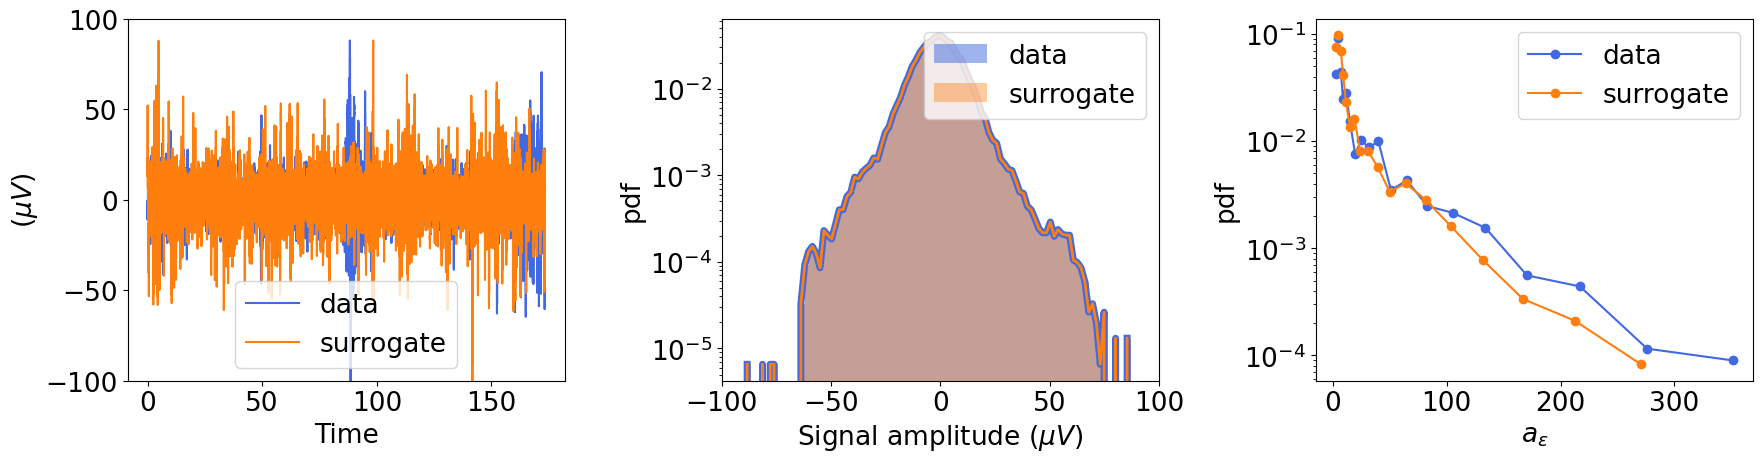

In [108]:
f =plt.figure(figsize =(18,5))
ax = f.add_subplot(1,3,1)
time = np.arange(0,len(data2[0]),1)/500
ax.plot(time,data2[0], label ='data',color ='royalblue')
ax.plot(time, xsurr2[0], label ='surrogate', color ='tab:orange')
ax.set_xlabel('Time')
ax.set_ylabel('($\mu V)$')
ax.set_ylim(-100,100)


ax.legend()
ax = f.add_subplot(1,3,2)

a,b,c = ax.hist(data2[3],bins = 100, density = True, color ='royalblue', alpha =.5,label='data');
ax.plot(b[:-1],a, color ='royalblue', lw=5)
a,b,c = ax.hist(xsurr2[3],bins = 100,density = True,color ='tab:orange', alpha = 0.4,label='surrogate');
ax.plot(b[:-1],a, color ='tab:orange', lw = 2)

ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_ylabel('pdf')
ax.set_xlabel('Signal amplitude ($\mu V)$')
ax.legend()
ax.set_xlim(-100,100)
ax = f.add_subplot(1,3,3)

pwl.plot_pdf(avalanche(data[0][np.newaxis,:].T,2)[0], color ='royalblue',marker ='o',linear_bins=False, ax =ax, label ='data')

pwl.plot_pdf(avalanche(xsurr[0][np.newaxis,:].T,2)[0], color ='tab:orange',marker ='o',linear_bins=False, label ='surrogate',ax= ax);
ax.set_xscale('linear')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('$a_\epsilon$')
ax.set_ylabel('pdf');
#plt.xscale('log')
plt.tight_layout();

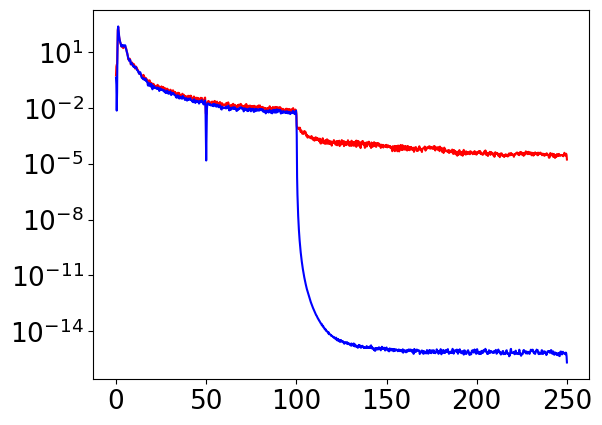

In [84]:
from scipy import signal
x,p = signal.welch(xsurr[3], fs = 500,nperseg = 500*5)
plt.plot(x,p, color = 'red')
x,p = signal.welch(data[3], fs = 500,nperseg = 500*5)
plt.plot(x,p, color = 'blue')
#plt.xlim(0.1,80)
#plt.ylim(10**-6.,10**3)
#plt.xscale('log')
plt.yscale('log')

(40000.0, 50000.0)

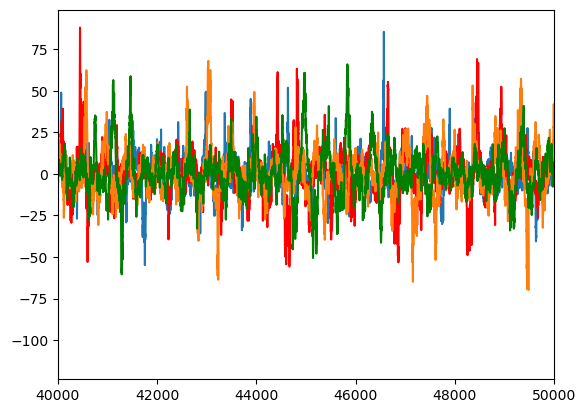

In [44]:
#plt.plot(data2[8])
plt.plot(xsurr2[8])
plt.plot(xsurr2[0], color ='red')

#plt.plot(data2[8])
plt.plot(xsurr2[2])
plt.plot(xsurr2[3], color ='green')

plt.xlim(500*80,500*100)
#plt.ylim(-50,50)

In [ ]:
##np.imag or np.real??

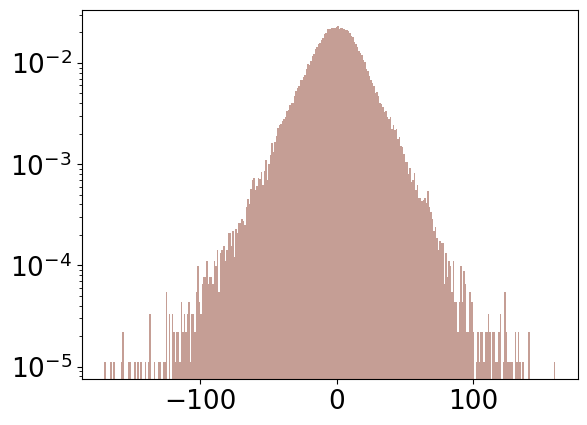

In [103]:
plt.hist(data2[0], bins = 300, density = True,  color ='royalblue', alpha =.5);
plt.hist(xsurr2[0], bins = 300,density = True,color ='tab:orange', alpha = 0.4);
plt.yscale('log')
#plt.xscale('log')

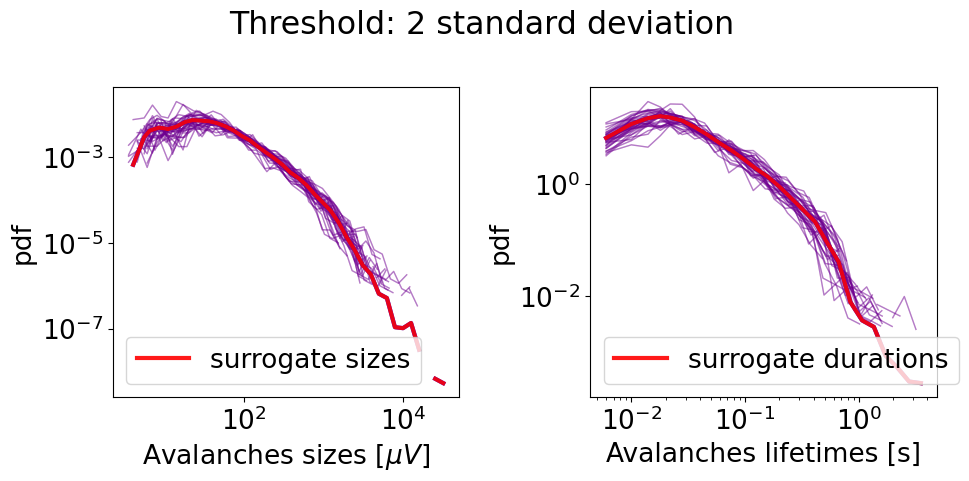

In [17]:
plot_surr(ss,dd,ss,dd)


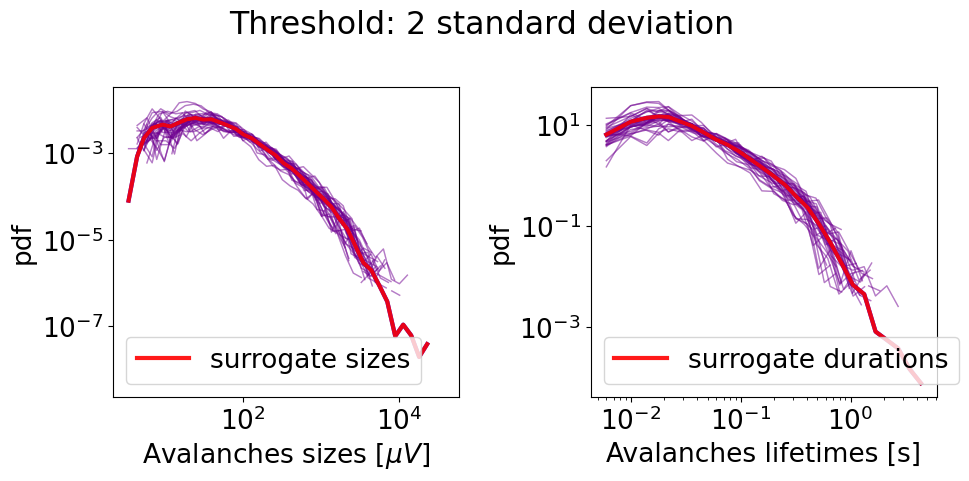

In [18]:
plot_surr(ss2,dd2,ss2,dd2)


Calculating best minimal value for power law fit


<Axes: >

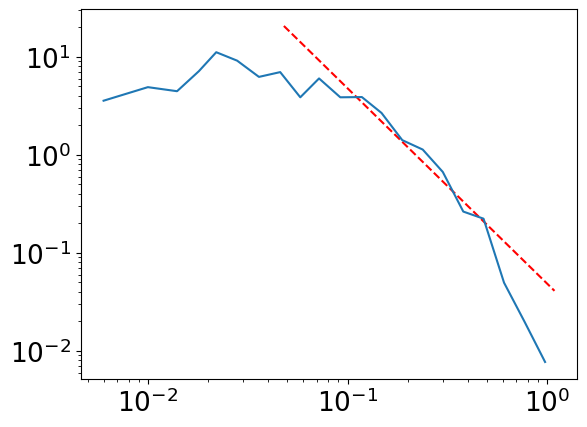

In [32]:
fit = pwl.Fit(dd[0], discrete = False,xmax =max(dd[0]), xmin = (0.,0.05), color = 'red')
fit.power_law.plot_pdf(color ='red', linestyle ='--')
pwl.plot_pdf(dd[0])

Calculating best minimal value for power law fit


<Axes: >

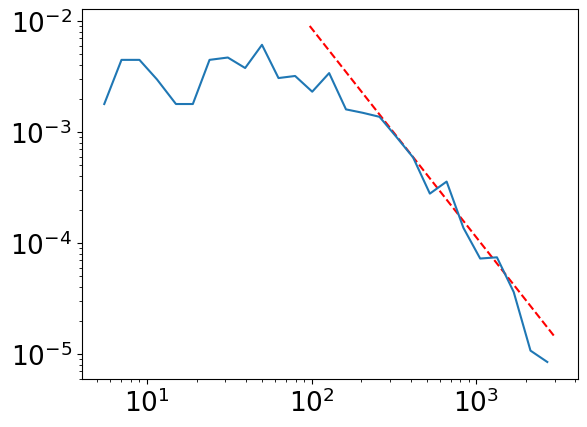

In [28]:
fit = pwl.Fit(ss[0], discrete = False,xmax =max(ss[0]), xmin = (1,100), color = 'red')
fit.power_law.plot_pdf(color ='red', linestyle ='--')
pwl.plot_pdf(ss[0])

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.139335556777239 +- 0.015474600733801665


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


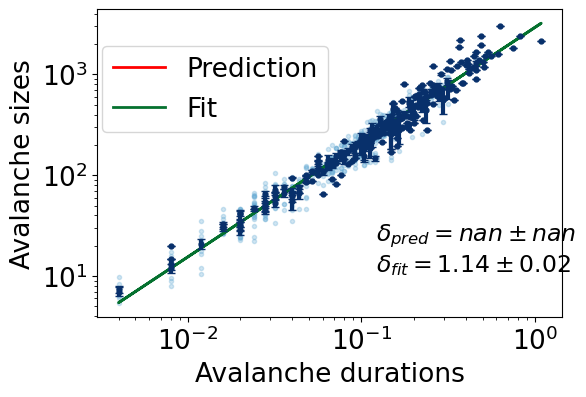

In [21]:
scaling(ss[0], dd[0], plotto =True);

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
C:\Users\Benedetta\anaconda3\lib\site-packages\powerlaw.py:1170: RuntimeWarning: invalid value encountered in double_scalars
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0893454657464514 +- 0.006899751695147876


C:\Users\Benedetta\Desktop\Criticality in barrel cortex\EEG avalanche analysis\ava_functions.py:619: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([pred, errpred,fit,errfit,a,b,c])


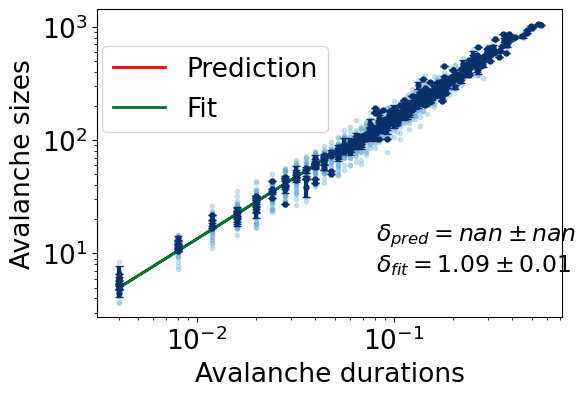

In [19]:
scaling(surrs[0], surrd[0], plotto =True);

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import powerlaw as pwl

# Avalanche exponents t-tests

In [33]:
filterr

True

In [34]:
### COMPARISON BETWEEN SILENCE1 AND SILENCE2

import os
import numpy as np
#import scipy.signal as ss
import scipy.io
#from dfa_functions import *

overlap =0.5
bands = [[1,3],[4,8],[8,13],[14,30],[31,60]]
labels = ['band-1', 'band-2', 'band-3', 'band-4', 'band-5']
subjs  = [5,6,9,11,12,13,16,17,18,19,21,23,24,25,30,33,34,35,37,39,40,45,47,49,52,53,56,57,58,60,62,63,65,66,67,68,69,71,14,20,22,27,28,29,31,41,46,64,70]
print(len(subjs))
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
from scipy.signal import welch
import pandas as pd
import mne

hh = 14
ch_names = ['F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8']
alphas1 = []
taus1 =[]

deltas1 = []
deltas2 = []


alphas2 = []
taus2 =[]



alphas1_surr = []
taus1_surr =[]

deltas1_surr = []
deltas2_surr = []


alphas2_surr = []
taus2_surr =[]

#good_sub = []


ch_names = np.array(ch_names)
sfreq = 500
info = mne.create_info(ch_names = list(ch_names),
                       ch_types = 'eeg',
                       sfreq = sfreq)
o = 0
for i, subj in enumerate(subjs):
    print(f'\n\n########## SUBJ {subj} ({i+1}/{len(subjs)})##########')
    s1 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence1 (continuous).mat')
    s2 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence2 (continuous).mat')
    data = s1['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    if idx_down > 0 or idx_up < data.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data.shape[1]:
            idx_up -= 1
        data = data[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data = data[list(idx_accepted), idx_down:idx_up]
    nchan = data.shape[0]
    
    data2 = s2['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    if idx_down > 0 or idx_up < data2.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data2.shape[1]:
            idx_up -= 1
        data2 = data2[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data2 = data2[list(idx_accepted), idx_down:idx_up]
    nchan2 = data2.shape[0]
    print(nchan, nchan2)
    if nchan >= 5 and nchan2 >=5 and subj != 53:
   
        b,a = signal.butter(2, 50, btype = 'lowpass',fs = 500)

        if filterr:
            dataa = signal.filtfilt(b,a, data, axis = -1)
            dataa2 = signal.filtfilt(b,a, data2, axis = -1)
        else:
            dataa = data
            dataa2 = data2
        
        print('doing')
        s,d = compute_avalanches(dataa.T,fs = 500,theta =2,discretized=False)
        s2,d2 =  compute_avalanches(dataa2.T,fs = 500,theta =2,discretized=False)
        #ss.append(s)
        #dd.append(d)
        #ss2.append(s2)
        #dd2.append(d2)
        
            
        v = scaling(s,d*0.002, plotto = False)

        deltas1.append(v[2])

        good_sub.append(subj)
        data = s
        fit = pwl.Fit(data,xmin =(1,100),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        alphas1.append(exp)
        
        data = d*0.002
        fit = pwl.Fit(data,xmin =(0,0.05),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        taus1.append(exp)

        data = s2
        fit = pwl.Fit(data,xmin =(1,100),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        alphas2.append(exp)
        
        data = d2*0.002
        fit = pwl.Fit(data,xmin =(0,0.05),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        taus2.append(exp)
        
        
        v = scaling(s2,d2*0.002, plotto = False)
        deltas2.append(v[2])
        
        
        
        
        s,d = compute_avalanches(AAFT_surrogates(dataa).T,theta=2, fs = 500,discretized=False)
        s2,d2 = compute_avalanches(AAFT_surrogates(dataa2).T,theta =2, fs =500,discretized=False)
        #ss.append(s)
        #dd.append(d)
        #ss2.append(s2)
        #dd2.append(d2)
        
            
        v = scaling(s,d*0.002, plotto = False)

        deltas1_surr.append(v[2])

        #good_sub.append(subj)
        data = s
        fit = pwl.Fit(data,xmin =(1,100),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        alphas1_surr.append(exp)
        
        data = d*0.002
        fit = pwl.Fit(data,xmin =(0,0.05),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        taus1_surr.append(exp)

        data = s2
        fit = pwl.Fit(data,xmin =(1,100),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        alphas2_surr.append(exp)
        
        data = d2*0.002
        fit = pwl.Fit(data,xmin =(0,0.05),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        taus2_surr.append(exp)
        
        
        v = scaling(s2,d2*0.002, plotto = False)
        deltas2_surr.append(v[2])
        
        

        o += 1
        

49


########## SUBJ 5 (1/49)##########
7 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.139335556777236 +- 0.01547460073380165
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1465212113567973 +- 0.012264462056445252
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0933072072743946 +- 0.007927889616937397
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1057251562061658 +- 0.006107983713972183


########## SUBJ 6 (2/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1278549910321911 +- 0.01169161377441174
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1286208745167354 +- 0.012446672603939524
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0668682243236838 +- 0.005403208313623259
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.056458547389197 +- 0.005723409776240722


########## SUBJ 9 (3/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0766564948829365 +- 0.010365990188637653
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1262556508008608 +- 0.011520647921896457
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0819996622824406 +- 0.006339953310463701
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0853363126019075 +- 0.005988635340310955


########## SUBJ 11 (4/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0947038138862863 +- 0.011568359941842122
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1205379337946548 +- 0.012016876936953016
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0716396328350009 +- 0.0058282548561763275
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0850828787839437 +- 0.006146552153636749


########## SUBJ 12 (5/49)##########
10 7
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1441576314855306 +- 0.011838545990015317
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1267107205435036 +- 0.01444098361313094
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0951289107066149 +- 0.00599857121524509
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.127613623695293 +- 0.007285242289742199


########## SUBJ 13 (6/49)##########
0 8


########## SUBJ 16 (7/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.131920405121259 +- 0.00999064369637058
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1455779918260092 +- 0.010828112688623595
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0646540507274922 +- 0.006120617546785708
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.070485804637461 +- 0.00541456685371889


########## SUBJ 17 (8/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.133133707462331 +- 0.011149582068893724
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.146234146416955 +- 0.01189873326285069
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0877710758021206 +- 0.006974580541590847
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.077829711848197 +- 0.0058126558501053254


########## SUBJ 18 (9/49)##########
8 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1044186014381774 +- 0.01173065796584052
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1283314967932507 +- 0.011080596634107823


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0926588262905135 +- 0.00648105547176241
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0717828396635933 +- 0.006253758918798072


########## SUBJ 19 (10/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1485442749680297 +- 0.011177001319570109
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1243716166860143 +- 0.010768374516927194
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0699086174330326 +- 0.006054169176952449
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0792697909190145 +- 0.006087638878265963


########## SUBJ 21 (11/49)##########
9 1


########## SUBJ 23 (12/49)##########
8 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0881000292528942 +- 0.014600876118666102


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1343402410842005 +- 0.011449829546699848
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.09295967305246 +- 0.006373331153941115
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.094399161838317 +- 0.005969031374776742


########## SUBJ 24 (13/49)##########
0 10


########## SUBJ 25 (14/49)##########
2 10


########## SUBJ 30 (15/49)##########
10 8
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1194793471343525 +- 0.01214441130219896
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1414573015544962 +- 0.011779014065368205


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0944035627265971 +- 0.005997101198765836
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0936856504116994 +- 0.006793026968987788


########## SUBJ 33 (16/49)##########
7 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0870427584870623 +- 0.011240479735557536
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1092983828111787 +- 0.010186524197343073
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1088961310400394 +- 0.007222030010884402
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0947004131784097 +- 0.006364230382946311


########## SUBJ 34 (17/49)##########
0 10


########## SUBJ 35 (18/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0879551760904516 +- 0.01071816951515281
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1449519299318769 +- 0.010053505918553746


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0870701196199741 +- 0.005662681851285462
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0660253260948276 +- 0.005869238789105485


########## SUBJ 37 (19/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0847475961712225 +- 0.013308668288035442
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1328046080148728 +- 0.011814292174191433


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0634854718992575 +- 0.005573042592487924
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0750402086034383 +- 0.005346285518964086


########## SUBJ 39 (20/49)##########
4 9


########## SUBJ 40 (21/49)##########
6 8
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0894821196023594 +- 0.010971443032782894
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1462102948204818 +- 0.011014746089282082
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0959656802431152 +- 0.0074982651619941
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0819146019595527 +- 0.0065287059813778315


########## SUBJ 45 (22/49)##########
9 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.109279183723906 +- 0.014622077375730142
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1350067046898542 +- 0.01119254193835423


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0932922093473174 +- 0.007380082552072912
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0937135170943821 +- 0.006111394138267812


########## SUBJ 47 (23/49)##########


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


9 7
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1227323428382 +- 0.011239608161856601
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1334072116414706 +- 0.0165768060290915


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0943455731511829 +- 0.006093534933657901
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1049412978067168 +- 0.006706095634799933


########## SUBJ 49 (24/49)##########
10 8
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1107996228357244 +- 0.01181441029519593
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0957514652979317 +- 0.0119704689495941
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0813261792519102 +- 0.006521245493958901
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.084746276303656 +- 0.006243652119863507


########## SUBJ 52 (25/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1703453419693481 +- 0.02201443367945945
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1485758875617906 +- 0.011395064495062408


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1055032893086214 +- 0.006452006600775849
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1197475334626634 +- 0.007210169016918341


########## SUBJ 53 (26/49)##########
5 9


########## SUBJ 56 (27/49)##########
10 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1123462523056014 +- 0.010693845788634445
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1559518738834396 +- 0.011658896645814983


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0859357758990356 +- 0.005818879679413675
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0787564132822733 +- 0.006337481342623073


########## SUBJ 57 (28/49)##########
2 10


########## SUBJ 58 (29/49)##########
10 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.130727611663294 +- 0.013211918722045702
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1187358764200572 +- 0.010013724539863284
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0899382791454983 +- 0.006370011559002121
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0591066469520882 +- 0.0058901766683241265


########## SUBJ 60 (30/49)##########
10 0


########## SUBJ 62 (31/49)##########
7 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.138761108691034 +- 0.014552472127921812
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.138791953780318 +- 0.014855897413400992


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0899179253736215 +- 0.006572678003445947
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1065491535369543 +- 0.007873802908423965


########## SUBJ 63 (32/49)##########


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


1 10


########## SUBJ 65 (33/49)##########
0 9


########## SUBJ 66 (34/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1113492390176591 +- 0.014898722743099082
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1157222539396305 +- 0.013644001894840049


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0776655339663033 +- 0.007766960193444564
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1206724486308994 +- 0.008190568441756365


########## SUBJ 67 (35/49)##########
10 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.138471035963377 +- 0.013110915671371218
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1112899175127318 +- 0.010934443013240197


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0930768052592654 +- 0.006484463805607983
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0918627470223492 +- 0.005667217469599003


########## SUBJ 68 (36/49)##########
8 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1239663774326132 +- 0.01215142978258676
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1431679441095293 +- 0.012833676659202868


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0978630552061237 +- 0.006963266773320687
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0822023148631712 +- 0.006174939592794822


########## SUBJ 69 (37/49)##########
3 10


########## SUBJ 71 (38/49)##########
6 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1601367128991176 +- 0.018533875777352257
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1446456873384439 +- 0.013727759030680556


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1199745458584278 +- 0.00822018324586971
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0975969930047231 +- 0.00687778033830757


########## SUBJ 14 (39/49)##########


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


5 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0608754319810278 +- 0.010918664470215915
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1258493984261735 +- 0.010649009455709455
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0849781188614271 +- 0.007584212999943485
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0835871251345361 +- 0.00613223832145493


########## SUBJ 20 (40/49)##########
0 10


########## SUBJ 22 (41/49)##########
8 8
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0531412374596159 +- 0.009451827492466001
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0845202888908587 +- 0.01148469025848504


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0642638395463306 +- 0.0057802402635684655
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.06714667236729 +- 0.005858119743158635


########## SUBJ 27 (42/49)##########
7 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.125582989207555 +- 0.011761899272472637
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1320609263723924 +- 0.009849455075036963


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0730514982612647 +- 0.006643117895111854
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.089232340143469 +- 0.006320748352161092


########## SUBJ 28 (43/49)##########


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


3 10


########## SUBJ 29 (44/49)##########
4 4


########## SUBJ 31 (45/49)##########
4 8


########## SUBJ 41 (46/49)##########
10 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1408902303579094 +- 0.012369695962364301
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1413445163202325 +- 0.010091142691259403


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0834249335775457 +- 0.006453684552346222
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0818973704167087 +- 0.00655860756182286


########## SUBJ 46 (47/49)##########
8 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1418078642937992 +- 0.021890397244765332
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1101734845461555 +- 0.010951922953858433


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.107917125200876 +- 0.007545104715427851
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0636724526158252 +- 0.0055259259425119505


########## SUBJ 64 (48/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.130873412732395 +- 0.010839572876341927
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1377206374447923 +- 0.011801472377115414


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
C:\Users\Benedetta\Desktop\Criticality in barrel cortex\EEG avalanche analysis\ava_functions.py:549: RuntimeWarning: divide by zero encountered in log10
  x = np.hstack((np.log10(a).reshape(-1,1), np.ones(len(a)).reshape(-1,1)))
C:\Users\Benedetta\Desktop\Criticality in barrel cortex\EEG avalanche analysis\ava_functions.py:551: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(b).reshape(-1,1)
Values less than or equal to 0 in data. Throwing out 0 or negative values


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  nan +- nan
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0780286124689011 +- 0.007004941747907529


########## SUBJ 70 (49/49)##########
0 3


Calculating best minimal value for power law fit


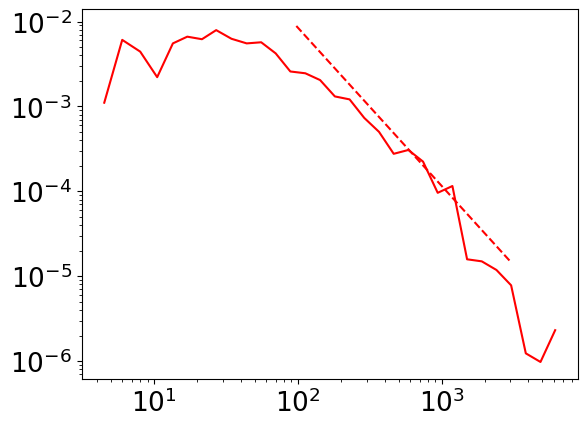

In [72]:
fit = pwl.Fit(ss[10], discrete = False,xmax =max(ss[0]), xmin = (1,100), )
fit.power_law.plot_pdf(color ='red', linestyle ='--')
pwl.plot_pdf(ss[10], color ='red');

Calculating best minimal value for power law fit


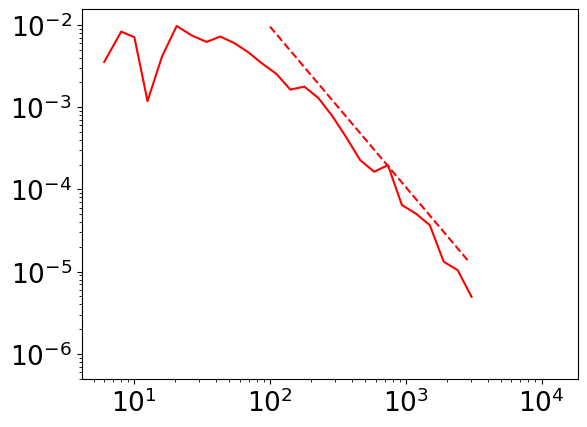

In [77]:
fit = pwl.Fit(ss[16], discrete = False,xmax =max(ss[0]), xmin = (1,100), )
fit.power_law.plot_pdf(color ='red', linestyle ='--')
pwl.plot_pdf(ss[16], color ='red');

In [48]:
good_sub = np.array([ 5,  6,  9, 11, 12, 16, 17, 18, 19, 23, 30, 33, 35, 37, 40, 45, 47,
       49, 52, 56, 58, 62, 66, 67, 68, 71, 14, 22, 27, 41, 46, 64])

In [49]:
### ORDER OF THE LANGUAGES
order = pd.read_excel('../../../Downloads/ordine lingue.xlsx')#1 en, 2 fr, 3 sp

In [50]:

subject_french = order[order["last language"]==2]["subject"].values

subject_en = order[order["last language"]==1]["subject"].values

subject_span = order[order["last language"]==3]["subject"].values

In [51]:
sub_fren = (list(set(subject_french) & set(good_sub)))
sub_span = (list(set(subject_span) & set(good_sub)))
sub_en = (list(set(subject_en) & set(good_sub)))


In [52]:
list(map(len, [sub_fren, sub_span, sub_en]))

[12, 9, 11]

In [53]:
good_sub = np.asarray(good_sub)
alphas1 = np.asarray(alphas1)
alphas2 = np.asarray(alphas2)
taus1 = np.asarray(taus1)
taus2 = np.asarray(taus2)
deltas1 = np.asarray(deltas1)
deltas2 = np.asarray(deltas2)
#index. = np.where()

In [54]:
good_sub = np.asarray(good_sub)
alphas1_surr = np.asarray(alphas1_surr)
alphas2_surr = np.asarray(alphas2_surr)
taus1_surr = np.asarray(taus1_surr)
taus2_surr = np.asarray(taus2_surr)
deltas1_surr = np.asarray(deltas1_surr)
deltas2_surr = np.asarray(deltas2_surr)
#index. = np.where()

In [55]:
h = []
for k in sub_fren:
    #if k in good_sub:
    #h.append(np.where(k == good_sub)[0])
    h.append(good_sub.tolist().index(k))
print(h)        
#np.concatenate(h)

[22, 23, 13, 2, 29, 3, 4, 16, 5, 7, 27, 19]


In [56]:
ll = np.concatenate([np.where(good_sub==i)[0] for i in sub_fren])

In [61]:
def funct2(sub, vec1):
    index = np.concatenate([np.where(good_sub==i)[0] for i in sub])
    #index = np.where(good_sub, sub_fren)
    al1 = vec1[index]
    #al2 = vec2[index]
    return al1
    #print(stats.

In [62]:
import scipy.stats as stats 

def funct(sub, vec1, vec2, option ='greater'):
    index = np.concatenate([np.where(good_sub==i)[0] for i in sub])
    #index = np.where(good_sub, sub_fren)
    al1 = vec1[index]
    al2 = vec2[index]
    print(stats.ttest_rel(al1, al2,alternative = option) )
    

In [63]:
funct2(sub_fren, alphas1).mean(),funct2(sub_fren, alphas2).mean()

(1.8811409511623463, 1.8340026356961037)

In [64]:
funct(sub_fren,alphas1_surr,alphas2_surr)
funct(sub_en,alphas1_surr,alphas2_surr)
funct(sub_span,alphas1_surr,alphas2_surr)

TtestResult(statistic=0.6293510429358705, pvalue=0.2709846187222613, df=11)
TtestResult(statistic=0.9816151056086819, pvalue=0.17472071991484556, df=10)
TtestResult(statistic=1.81429068973048, pvalue=0.05359233731109065, df=8)


In [78]:
funct(sub_fren,alphas1,alphas2) ## FRENCH IS SIGNIFICANT
funct(sub_en,alphas1,alphas2)
funct(sub_span,alphas1,alphas2)

TtestResult(statistic=1.3777125045795462, pvalue=0.09783716801228601, df=11)
TtestResult(statistic=0.6823373058012522, pvalue=0.25526069291276055, df=10)
TtestResult(statistic=0.5530267026631586, pvalue=0.2976783422460515, df=8)


In [67]:
funct(sub_fren,taus1,taus2)
funct(sub_en,taus1,taus2)
funct(sub_span,taus1,taus2)

TtestResult(statistic=0.0986804976729407, pvalue=0.4615836274643028, df=11)
TtestResult(statistic=-2.596760343115305, pvalue=0.986680416046319, df=10)
TtestResult(statistic=-0.3893652962831532, pvalue=0.6464171671962261, df=8)


In [68]:
funct(sub_fren,deltas1,deltas2, 'less') # FRENCH IS SIGNIFICANTE
funct(sub_en,deltas1,deltas2, 'less')
funct(sub_span,deltas1,deltas2, 'less')

TtestResult(statistic=-2.422126679578228, pvalue=0.016939509288613756, df=11)
TtestResult(statistic=-1.3560320817798128, pvalue=0.10245846852889438, df=10)
TtestResult(statistic=-1.122074338999741, pvalue=0.14718849652937047, df=8)


In [30]:
# Importing library 
import scipy.stats as stats 
alphas1 =np.asarray(alphas1)
alphas2 =np.asarray(alphas2)

stats.ttest_rel(alphas1, alphas2,alternative = 'greater') 


TtestResult(statistic=1.7072676433503748, pvalue=0.048885502831148446, df=31)

In [32]:
# Importing library 
import scipy.stats as stats 
alphas1 =np.asarray(alphas1)
alphas2 =np.asarray(alphas2)

stats.ttest_rel(deltas1, deltas2,alternative = 'less') 

TtestResult(statistic=-3.06359372422484, pvalue=0.0022491829534972787, df=31)

In [35]:
# Importing library 
import scipy.stats as stats 
alphas1 =np.asarray(alphas1)
alphas2 =np.asarray(alphas2)

stats.ttest_rel(taus1, taus2,alternative = 'greater') 

TtestResult(statistic=-1.118319191046327, pvalue=0.8639888790049307, df=31)

In [38]:
# Importing library 
import scipy.stats as stats 
taus1 =np.asarray(taus1)
taus2 =np.asarray(taus2)

stats.ttest_rel(taus1, taus2,) 

TtestResult(statistic=-1.015727777328112, pvalue=0.3173776932365956, df=32)

In [31]:
stats.ttest_rel(deltas1, deltas2,alternative = 'less') 

TtestResult(statistic=-2.6655888161610273, pvalue=0.005972661835473558, df=32)

In [39]:
plt.rcParams['font.size'] = 17

In [79]:
a_frenc1 = funct2(sub_fren, np.asarray(alphas1))
a_frenc2 = funct2(sub_fren, np.asarray(alphas2))

a_span1 = funct2(sub_span, np.asarray(alphas1))
a_span2 = funct2(sub_span, np.asarray(alphas2))

a_eng1 = funct2(sub_en, np.asarray(alphas1))
a_eng2 = funct2(sub_en, np.asarray(alphas2))

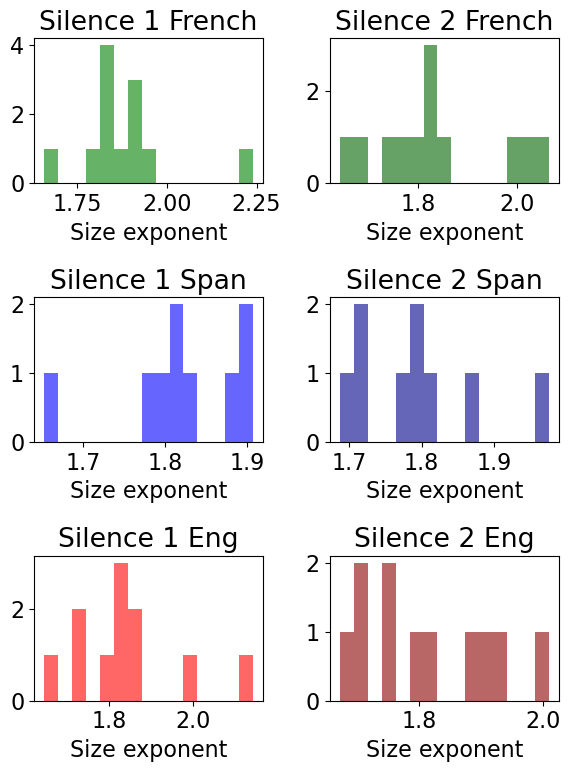

In [80]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize = (6,8))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)


ax1.hist(a_frenc1, color = 'green', alpha = .6, bins = 15)
ax2.hist(a_frenc2, color = 'darkgreen', alpha = .6, bins = 15)
ax1.set_title('Silence 1 French')
ax2.set_title('Silence 2 French')

ax1.set_xlabel('Size exponent')
ax2.set_xlabel('Size exponent')

ax3.hist(a_span1, color = 'blue', alpha = .6, bins = 15)
ax4.hist(a_span2, color = 'darkblue', alpha = .6, bins = 15)
ax3.set_title('Silence 1 Span')
ax4.set_title('Silence 2 Span')

ax3.set_xlabel('Size exponent')
ax4.set_xlabel('Size exponent')

ax5.hist(a_eng1, color = 'red', alpha = .6, bins = 15)
ax6.hist(a_eng2, color = 'darkred', alpha = .6, bins = 15)
ax5.set_title('Silence 1 Eng')
ax6.set_title('Silence 2 Eng')

ax5.set_xlabel('Size exponent')
ax6.set_xlabel('Size exponent')
plt.tight_layout();

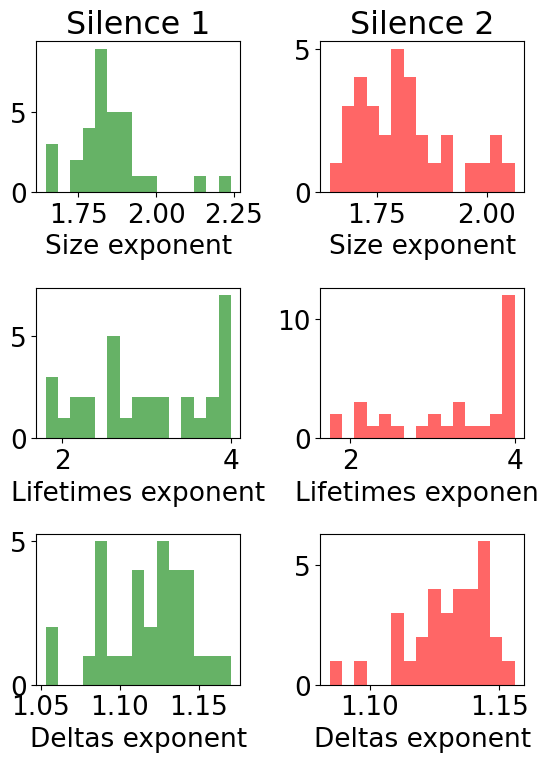

In [69]:
fig = plt.figure(figsize = (6,8))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)


ax1.hist(alphas1, color = 'green', alpha = .6, bins = 15)
ax2.hist(alphas2, color = 'red', alpha = .6, bins = 15)
ax1.set_title('Silence 1')
ax2.set_title('Silence 2')

ax1.set_xlabel('Size exponent')
ax2.set_xlabel('Size exponent')


#ax3.set_title('Silence 1')
#ax4.set_title('Silence 2')
ax3.hist(taus1, color = 'green', alpha = .6, bins = 15)
ax4.hist(taus2, color = 'red', alpha = .6, bins = 15)
ax3.set_xlabel('Lifetimes exponent')
ax4.set_xlabel('Lifetimes exponent')


#ax5.set_title('Silence 1')
#ax6.set_title('Silence 2')
ax5.hist(deltas1, color = 'green', alpha = .6, bins = 15)
ax6.hist(deltas2, color = 'red', alpha = .6, bins = 15)
ax5.set_xlabel('Deltas exponent');
ax6.set_xlabel('Deltas exponent');
plt.tight_layout();
